### Import Libraries

In [1]:
#Import Cell
import torch
from torch.autograd import Variable
import numpy as np
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from time import time
import re
import json
import astropy
from astropy.stats import histogram
from scipy import stats
import astropy.units as u
import astropy.constants as constant
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.units import dimensionless
import pandas as pd
import tqdm as tqdm
from tqdm import tqdm
import importlib
print(f'Pytorch version {torch.__version__}')


Pytorch version 2.0.1


In [16]:
sys.path.append('../scripts/')
import potential_torch
import flow_torch
import toy_systems

Pytorch version 2.0.1
Pytorch version 2.0.1


### Set parameters

In [69]:
G = 1 #Gravitational Constant
M = 1 #Scale Mass
b = np.arange(0.1,10,.1) #Scale Constant
n_samples = 1000 #Number of Samples
n_averaged = 100 #Number of Mocks averaged over


### Define Necessary Functions

In [66]:
def sfurical(x,y,z,v_x,v_y,v_z):
    
    R = np.sqrt(x**2+y**2) #for convenience
    r = np.sqrt(x**2+y**2+z**2)

    theta = np.arccos(z/r)
    phi   = np.arctan2(y,x)

    # (vx,vy,vz) -> (vr,v_{\theta},v_{\phi})
    vr     =  ( x * v_x  + y * v_y + z * v_z )/ r    
    vphi   = (y * v_x - x * v_y)/ R
    vtheta = (z * x * v_x/R  + z * y * v_y/R - R * v_z)/r
    return r, vr, vtheta, vphi

def dispersion(v):
    return np.sqrt(sum(np.square(np.subtract(v,sum(v)/len(v))))/len(v))

def vd(r,vr,vtheta,vphi,t):
    N , bin_edges= histogram(r[t],bins='blocks')
    r_center = (bin_edges[:-1] + bin_edges[1:])/2
    vmean ,_,__  = stats.binned_statistic(r[t],vr[t], statistic = 'mean', bins = bin_edges)
    error = np.multiply(1/np.sqrt(N),vmean)
    vdr     ,_,__ = stats.binned_statistic(r[t],vr[t], statistic = dispersion, bins = bin_edges)
    vdtheta     ,_,__ = stats.binned_statistic(r[t],vtheta[t], statistic = dispersion, bins = bin_edges)
    vdphi     ,_,__ = stats.binned_statistic(r[t],vphi[t], statistic = dispersion, bins = bin_edges)
    return r_center, vdr, vdtheta, vdphi

def variance(vd,vd_ideal):
    sqdiff = ((vd - vd_ideal)/vd_ideal)**2
    variance = np.square(sum(sqdiff))/len(sqdiff)
    return variance

vdlytic = lambda G, M, b, r : np.sqrt(G*M/(6*np.sqrt(b**2+r**2)))

### Generate Data

In [71]:
vdr = []
vdtheta = []
vdphi = []
for i in tqdm(range(0,len(b))):
    print('generating velocity dispersions for scale radius ' + str(b[i]))
    plummer_sphere = toy_systems.PlummerSphere(G,M,b[i])
    def sample_df(n_samples, max_dist=None):
        """
        Returns phase-space locations sampled from the Plummer sphere
        distribution function. The shape of the output is
        (n_samples, 6).
        """
        #Generates coordinates in phase-space from that lie in a spherical spatial region.
        x,v = plummer_sphere.sample_df(n_samples)
        if max_dist is not None:
            r2 = np.sum(x**2, axis=1)
            idx = (r2 < max_dist**2)
            x = x[idx]
            v = v[idx]
        return x , v

    vdr_avg = []
    vdtheta_avg = []
    vdphi_avg = []

    for m in tqdm(range(0,n_averaged)):

        q, p = sample_df(n_samples) #Generate Mock Data
        r, vr, vtheta, vphi = sfurical(q.T[0],q.T[1],q.T[2],p.T[0],p.T[1],p.T[2]) #Convert to spherical coordinates
        N , bin_edges= histogram(r,bins='blocks') #bin data
        r_center = (bin_edges[:-1] + bin_edges[1:])/2 #define bin centers
        
        #Calculate binning errors
        vmean ,_,__  = stats.binned_statistic(r,vr, statistic = 'mean', bins = bin_edges)
        error = np.multiply(1/np.sqrt(N),vmean)

        #Calculate velocity dispersions
        vdr0     ,_,__ = stats.binned_statistic(r,vr, statistic = dispersion, bins = bin_edges)
        vdtheta0     ,_,__ = stats.binned_statistic(r,vtheta, statistic = dispersion, bins = bin_edges)
        vdphi0     ,_,__ = stats.binned_statistic(r,vphi, statistic = dispersion, bins = bin_edges)   
        vd_ideal0 = vdlytic(G,M,b[i],r_center)

        #Calculate normalized variance from ideal
        vdr_avg += [variance(vdr0,vd_ideal0)]
        vdtheta_avg += [variance(vdtheta0,vd_ideal0)]
        vdphi_avg += [variance(vdphi0,vd_ideal0)]

    vdr += [sum(vdr_avg)/n_averaged]
    vdtheta += [sum(vdtheta_avg)/n_averaged]
    vdphi += [sum(vdphi_avg)/n_averaged]



  0%|          | 0/99 [00:00<?, ?it/s]

generating velocity dispersions for scale radius 0.1


  1%|          | 1/99 [00:19<31:55, 19.55s/it]

generating velocity dispersions for scale radius 0.2


  2%|▏         | 2/99 [00:38<30:56, 19.14s/it]

generating velocity dispersions for scale radius 0.30000000000000004


  3%|▎         | 3/99 [00:57<30:17, 18.94s/it]

generating velocity dispersions for scale radius 0.4


  4%|▍         | 4/99 [01:15<29:43, 18.78s/it]

generating velocity dispersions for scale radius 0.5


  5%|▌         | 5/99 [01:28<26:07, 16.67s/it]

generating velocity dispersions for scale radius 0.6


  6%|▌         | 6/99 [01:41<23:52, 15.41s/it]

generating velocity dispersions for scale radius 0.7000000000000001


  7%|▋         | 7/99 [01:54<22:22, 14.59s/it]

generating velocity dispersions for scale radius 0.8


  8%|▊         | 8/99 [02:07<21:18, 14.05s/it]

generating velocity dispersions for scale radius 0.9


  9%|▉         | 9/99 [02:20<20:30, 13.67s/it]

generating velocity dispersions for scale radius 1.0


 10%|█         | 10/99 [02:33<20:04, 13.53s/it]

generating velocity dispersions for scale radius 1.1


 11%|█         | 11/99 [02:46<19:33, 13.34s/it]

generating velocity dispersions for scale radius 1.2000000000000002


 12%|█▏        | 12/99 [02:59<19:08, 13.20s/it]

generating velocity dispersions for scale radius 1.3000000000000003


 13%|█▎        | 13/99 [03:12<18:47, 13.11s/it]

generating velocity dispersions for scale radius 1.4000000000000001


 14%|█▍        | 14/99 [03:24<18:27, 13.03s/it]

generating velocity dispersions for scale radius 1.5000000000000002


 15%|█▌        | 15/99 [03:37<18:10, 12.98s/it]

generating velocity dispersions for scale radius 1.6


 16%|█▌        | 16/99 [03:50<17:54, 12.94s/it]

generating velocity dispersions for scale radius 1.7000000000000002


 17%|█▋        | 17/99 [04:03<17:39, 12.93s/it]

generating velocity dispersions for scale radius 1.8000000000000003


 18%|█▊        | 18/99 [04:16<17:24, 12.90s/it]

generating velocity dispersions for scale radius 1.9000000000000001


 19%|█▉        | 19/99 [04:29<17:10, 12.89s/it]

generating velocity dispersions for scale radius 2.0


 20%|██        | 20/99 [04:42<16:56, 12.86s/it]

generating velocity dispersions for scale radius 2.1


 21%|██        | 21/99 [04:54<16:43, 12.87s/it]

generating velocity dispersions for scale radius 2.2


 22%|██▏       | 22/99 [05:07<16:30, 12.87s/it]

generating velocity dispersions for scale radius 2.3000000000000003


 23%|██▎       | 23/99 [05:20<16:16, 12.85s/it]

generating velocity dispersions for scale radius 2.4000000000000004


 24%|██▍       | 24/99 [05:33<16:04, 12.86s/it]

generating velocity dispersions for scale radius 2.5000000000000004


 25%|██▌       | 25/99 [05:46<15:50, 12.85s/it]

generating velocity dispersions for scale radius 2.6


 26%|██▋       | 26/99 [05:59<15:35, 12.82s/it]

generating velocity dispersions for scale radius 2.7


 27%|██▋       | 27/99 [06:11<15:22, 12.81s/it]

generating velocity dispersions for scale radius 2.8000000000000003


 28%|██▊       | 28/99 [06:24<15:09, 12.81s/it]

generating velocity dispersions for scale radius 2.9000000000000004


 29%|██▉       | 29/99 [06:37<14:56, 12.80s/it]

generating velocity dispersions for scale radius 3.0000000000000004


 30%|███       | 30/99 [06:50<14:43, 12.81s/it]

generating velocity dispersions for scale radius 3.1


 31%|███▏      | 31/99 [07:03<14:31, 12.81s/it]

generating velocity dispersions for scale radius 3.2


 32%|███▏      | 32/99 [07:15<14:18, 12.81s/it]

generating velocity dispersions for scale radius 3.3000000000000003


 33%|███▎      | 33/99 [07:28<14:06, 12.82s/it]

generating velocity dispersions for scale radius 3.4000000000000004


 34%|███▍      | 34/99 [07:41<13:59, 12.91s/it]

generating velocity dispersions for scale radius 3.5000000000000004


 35%|███▌      | 35/99 [07:54<13:45, 12.90s/it]

generating velocity dispersions for scale radius 3.6


 36%|███▋      | 36/99 [08:07<13:33, 12.91s/it]

generating velocity dispersions for scale radius 3.7


 37%|███▋      | 37/99 [08:20<13:21, 12.93s/it]

generating velocity dispersions for scale radius 3.8000000000000003


 38%|███▊      | 38/99 [08:33<13:11, 12.98s/it]

generating velocity dispersions for scale radius 3.9000000000000004


 39%|███▉      | 39/99 [08:46<12:58, 12.97s/it]

generating velocity dispersions for scale radius 4.0


 40%|████      | 40/99 [08:59<12:47, 13.01s/it]

generating velocity dispersions for scale radius 4.1


 41%|████▏     | 41/99 [09:12<12:35, 13.02s/it]

generating velocity dispersions for scale radius 4.2


 42%|████▏     | 42/99 [09:25<12:20, 12.98s/it]

generating velocity dispersions for scale radius 4.3


 43%|████▎     | 43/99 [09:38<12:04, 12.94s/it]

generating velocity dispersions for scale radius 4.3999999999999995


 44%|████▍     | 44/99 [09:51<11:49, 12.90s/it]

generating velocity dispersions for scale radius 4.5


 45%|████▌     | 45/99 [10:04<11:36, 12.89s/it]

generating velocity dispersions for scale radius 4.6


 46%|████▋     | 46/99 [10:16<11:21, 12.86s/it]

generating velocity dispersions for scale radius 4.7


 47%|████▋     | 47/99 [10:30<11:11, 12.91s/it]

generating velocity dispersions for scale radius 4.8


 48%|████▊     | 48/99 [10:42<10:57, 12.89s/it]

generating velocity dispersions for scale radius 4.9


 49%|████▉     | 49/99 [10:55<10:44, 12.90s/it]

generating velocity dispersions for scale radius 5.0


 51%|█████     | 50/99 [11:08<10:30, 12.88s/it]

generating velocity dispersions for scale radius 5.1


 52%|█████▏    | 51/99 [11:21<10:17, 12.87s/it]

generating velocity dispersions for scale radius 5.2


 53%|█████▎    | 52/99 [11:34<10:04, 12.87s/it]

generating velocity dispersions for scale radius 5.3


 54%|█████▎    | 53/99 [11:47<09:52, 12.87s/it]

generating velocity dispersions for scale radius 5.4


 55%|█████▍    | 54/99 [12:00<09:38, 12.86s/it]

generating velocity dispersions for scale radius 5.5


 56%|█████▌    | 55/99 [12:12<09:25, 12.85s/it]

generating velocity dispersions for scale radius 5.6


 57%|█████▋    | 56/99 [12:25<09:12, 12.84s/it]

generating velocity dispersions for scale radius 5.7


 58%|█████▊    | 57/99 [12:38<08:58, 12.83s/it]

generating velocity dispersions for scale radius 5.8


 59%|█████▊    | 58/99 [12:51<08:46, 12.84s/it]

generating velocity dispersions for scale radius 5.9


 60%|█████▉    | 59/99 [13:04<08:33, 12.84s/it]

generating velocity dispersions for scale radius 6.0


 61%|██████    | 60/99 [13:17<08:20, 12.84s/it]

generating velocity dispersions for scale radius 6.1


 62%|██████▏   | 61/99 [13:29<08:08, 12.84s/it]

generating velocity dispersions for scale radius 6.2


 63%|██████▎   | 62/99 [13:42<07:55, 12.86s/it]

generating velocity dispersions for scale radius 6.3


 64%|██████▎   | 63/99 [13:55<07:42, 12.85s/it]

generating velocity dispersions for scale radius 6.4


 65%|██████▍   | 64/99 [14:08<07:29, 12.84s/it]

generating velocity dispersions for scale radius 6.5


 66%|██████▌   | 65/99 [14:21<07:16, 12.83s/it]

generating velocity dispersions for scale radius 6.6


 67%|██████▋   | 66/99 [14:34<07:03, 12.85s/it]

generating velocity dispersions for scale radius 6.7


 68%|██████▊   | 67/99 [14:46<06:50, 12.83s/it]

generating velocity dispersions for scale radius 6.8


 69%|██████▊   | 68/99 [14:59<06:37, 12.83s/it]

generating velocity dispersions for scale radius 6.9


 70%|██████▉   | 69/99 [15:12<06:24, 12.83s/it]

generating velocity dispersions for scale radius 7.0


 71%|███████   | 70/99 [15:25<06:12, 12.83s/it]

generating velocity dispersions for scale radius 7.1


 72%|███████▏  | 71/99 [15:38<05:59, 12.83s/it]

generating velocity dispersions for scale radius 7.2


 73%|███████▎  | 72/99 [15:51<05:46, 12.84s/it]

generating velocity dispersions for scale radius 7.3


 74%|███████▎  | 73/99 [16:03<05:34, 12.86s/it]

generating velocity dispersions for scale radius 7.4


 75%|███████▍  | 74/99 [16:16<05:21, 12.86s/it]

generating velocity dispersions for scale radius 7.5


 76%|███████▌  | 75/99 [16:29<05:08, 12.87s/it]

generating velocity dispersions for scale radius 7.6


 77%|███████▋  | 76/99 [16:42<04:55, 12.87s/it]

generating velocity dispersions for scale radius 7.7


 78%|███████▊  | 77/99 [16:55<04:43, 12.87s/it]

generating velocity dispersions for scale radius 7.8


 79%|███████▉  | 78/99 [17:08<04:30, 12.88s/it]

generating velocity dispersions for scale radius 7.9


 80%|███████▉  | 79/99 [17:21<04:17, 12.88s/it]

generating velocity dispersions for scale radius 8.0


 81%|████████  | 80/99 [17:34<04:04, 12.86s/it]

generating velocity dispersions for scale radius 8.1


 82%|████████▏ | 81/99 [17:47<03:52, 12.91s/it]

generating velocity dispersions for scale radius 8.2


 83%|████████▎ | 82/99 [18:00<03:39, 12.94s/it]

generating velocity dispersions for scale radius 8.3


 84%|████████▍ | 83/99 [18:13<03:27, 12.94s/it]

generating velocity dispersions for scale radius 8.4


 85%|████████▍ | 84/99 [18:26<03:14, 12.97s/it]

generating velocity dispersions for scale radius 8.5


 86%|████████▌ | 85/99 [18:39<03:01, 12.98s/it]

generating velocity dispersions for scale radius 8.6


 87%|████████▋ | 86/99 [18:52<02:48, 12.98s/it]

generating velocity dispersions for scale radius 8.7


 88%|████████▊ | 87/99 [19:05<02:35, 12.99s/it]

generating velocity dispersions for scale radius 8.8


 89%|████████▉ | 88/99 [19:18<02:22, 12.99s/it]

generating velocity dispersions for scale radius 8.9


 90%|████████▉ | 89/99 [19:30<02:09, 12.97s/it]

generating velocity dispersions for scale radius 9.0


 91%|█████████ | 90/99 [19:44<01:56, 13.00s/it]

generating velocity dispersions for scale radius 9.1


 92%|█████████▏| 91/99 [19:57<01:44, 13.02s/it]

generating velocity dispersions for scale radius 9.2


 93%|█████████▎| 92/99 [20:10<01:30, 13.00s/it]

generating velocity dispersions for scale radius 9.3


 94%|█████████▍| 93/99 [20:23<01:17, 13.00s/it]

generating velocity dispersions for scale radius 9.4


 95%|█████████▍| 94/99 [20:36<01:05, 13.01s/it]

generating velocity dispersions for scale radius 9.5


 96%|█████████▌| 95/99 [20:49<00:52, 13.01s/it]

generating velocity dispersions for scale radius 9.6


 97%|█████████▋| 96/99 [21:02<00:38, 12.97s/it]

generating velocity dispersions for scale radius 9.700000000000001


 98%|█████████▊| 97/99 [21:14<00:25, 12.93s/it]

generating velocity dispersions for scale radius 9.8


 99%|█████████▉| 98/99 [21:27<00:12, 12.92s/it]

generating velocity dispersions for scale radius 9.9


100%|██████████| 99/99 [21:40<00:00, 13.14s/it]


### Plot Results

(0.0, 0.25)

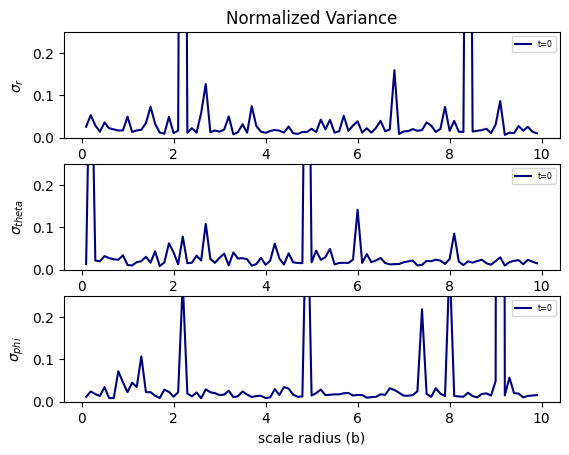

In [77]:
    figure, axis = plt.subplots(3, 1)
    plt.subplots_adjust(hspace = .25)
    ymax = .25


    #First plot - Radial Dispersions
    axis[0].plot(b,vdr, label = 't=0', color = 'navy')
    axis[0].set_ylabel('$\sigma_r$')
    axis[0].set_title('Normalized Variance')
    axis[0].legend(fontsize = 'xx-small')
    axis[0].set_ylim(0,ymax)

    #Second Plot - Theta Dispersions
    axis[1].plot(b,vdtheta, label = 't=0', color = 'navy')
    axis[1].set_ylabel('$\sigma_{theta}$')
    axis[1].legend(fontsize= 'xx-small')
    axis[1].set_ylim(0,ymax)

    #Third Plot - Phi Dispersions
    axis[2].plot(b,vdphi, label = 't=0', color = 'navy')
    axis[2].set_xlabel('scale radius (b)')
    axis[2].set_ylabel('$\sigma_{phi}$')
    axis[2].legend(fontsize= 'xx-small')
    axis[2].set_ylim(0,ymax)